# Download the CelebA dataset

In [1]:
import os
import zipfile
import requests

from tqdm import tqdm

In [2]:
def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination, chunk_size=32*1024):
    total_size = int(response.headers.get('content-length', 0))
    with open(destination, "wb") as f:
        for chunk in tqdm(response.iter_content(chunk_size), total=total_size, 
                          unit='B', unit_scale=True, desc=destination):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_file_from_google_drive(id, destination):
    print("Downloading into ./data/... Please wait.")
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    
    response = session.get(URL, params={ 'id': id }, stream=True)
    token = get_confirm_token(response)
    
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)
    print("Done.")

In [3]:
def download_celeb_a(dirpath):
    dirpath = './data'
    data_dir = 'celebA'
    if os.path.exists(os.path.join(dirpath, data_dir)):
        print('Found Celeb-A - skip')
        return

    filename, drive_id  = "img_align_celeba.zip", "0B7EVK8r0v71pZjFTYXZWM3FlRnM"
    save_path = os.path.join(dirpath, filename)

    if os.path.exists(save_path):
        print('[*] {} already exists'.format(save_path))
    else:
        download_file_from_google_drive(drive_id, save_path)

    zip_dir = ''
    with zipfile.ZipFile(save_path) as zf:
        zip_dir = zf.namelist()[0]
        zf.extractall(dirpath)
    os.remove(save_path)
    os.rename(os.path.join(dirpath, zip_dir), os.path.join(dirpath, data_dir))

In [4]:
dirpath = './data'
#download_celeb_a(dirpath)

# Preprocess the CelebA dataset and Batch them

In [5]:
%matplotlib inline
import os
import math
import numpy as np

from glob import glob
from matplotlib import pyplot as plt
from PIL import Image

In [6]:
# Image configuration
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
data_files = glob(os.path.join(dirpath, 'celebA/*.jpg')) # list of all '.jpg' files
shape = (len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [7]:
def get_image(image_path, width, height, mode):
    """
    Read an image from image_path, and crop/resize the image
    """
    image = Image.open(image_path)
    
    if image.size != (width, height):
        # Remove pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

In [8]:
def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single batch
    """
    data_batch = np.array(
        [get_image(sample_file, width, height, mode)
         for sample_file in image_files]).astype(np.float32)
    
    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape((1,) + data_batch.shape)
        
    return data_batch

In [9]:
def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255
    
    cur_index = 0
    while cur_index + batch_size <= shape[0]:
        data_batch = get_batch(data_files[cur_index:cur_index + batch_size], *shape[1:3])
        cur_index += batch_size
        yield data_batch / IMAGE_MAX_VALUE - 0.5

In [10]:
def images_square_grid(images, mode='RGB'):
    """
    Helper function to save images as a square grid (visualization)
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))
    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

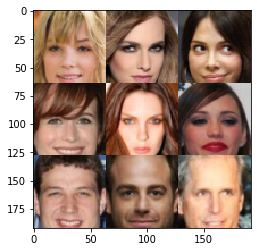

In [11]:
test_images = get_batch(glob(os.path.join(dirpath, 'celebA/*.jpg'))[:10], shape[1], shape[2])
plt.imshow(images_square_grid(test_images))

# Define placeholders

In [12]:
import tensorflow as tf

/home/ds4user11/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ds4user11/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ds4user11/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ds4user11/minico

In [13]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32,
                                shape = (None, image_width, image_height, image_channels),
                                name = 'input_real')
    inputs_z = tf.placeholder(tf.float32,
                             shape=(None, z_dim),
                              name = 'input_z')
    learning_rate = tf.placeholder(tf.float32,
                                  name = 'learning_rate')
    return inputs_real,inputs_z, learning_rate

# Discriminator network

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # Conv 1
        print(f'dis/images:{images.shape}')
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        print(f'dis/lrelu1:{lrelu1.shape}')
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        print(f'dis/lrelu2:{lrelu2.shape}')
        conv3 = tf.layers.conv2d(lrelu2, 128, 5, 2, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        # Flatten
        print(f'dis/Irelu3:{lrelu3.shape}')
        flat = tf.reshape(lrelu3, (-1, 8 * 8 * 128))
        
        # Logits
        print(f'dis/flat:{flat.shape}')
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

# Generator network

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse = False if is_train else True):
        print(f'gen/z:{z.shape}')
        x_1 = tf.layers.dense(z, 2*2*512)
        
        print(f'gen/x_1:{x_1.shape}')
        deconv_2 = tf.reshape(x_1,(-1,2,2,512))
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training = is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        print(f'gen/lrelu2:{lrelu2.shape}')
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256,5,4, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training= is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        print(f'gen/lrelu3:{lrelu3.shape}')
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128,5,4,padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training = is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        print(f'gen/lrelu4:{lrelu4.shape}')
        logits = tf.layers.conv2d_transpose(lrelu4,out_channel_dim,5,2,padding='SAME')
        
        print(f'gen/logits:{logits.shape}')
        out = tf.tanh(logits)
        
        return out
        

# Loss functions

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    label_smoothing = 0.9

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real) * label_smoothing))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    return d_loss, g_loss

# Parameter optimization

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

# Visualization

In [18]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    plt.imshow(images_square_grid(samples))
    plt.show()

# Training

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images * 2
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images, input_z: batch_z})
                
                if steps % 400 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3])

(202599, 64, 64, 3)
gen/z:(?, 100)
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
gen/x_1:(?, 2048)
Instructions for updating:
Use keras.layers.batch_normalization instead.
gen/lrelu2:(?, 2, 2, 512)
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)
dis/images:(?, 64, 64, 3)
Instructions for updating:
Use keras.layers.conv2d instead.
dis/lrelu1:(?, 32, 32, 64)
dis/lrelu2:(?, 16, 16, 128)
dis/Irelu3:(?, 8, 8, 128)
dis/flat:(?, 8192)
dis/images:(?, 64, 64, 3)
dis/lrelu1:(?, 32, 32, 64)
dis/lrelu2:(?, 16, 16, 128)
dis/Irelu3:(?, 8, 8, 128)
dis/flat:(?, 8192)
Epoch 1/10... Discriminator Loss: 1.3340... Generator Loss: 0.7790
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


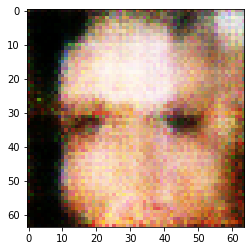

Epoch 1/10... Discriminator Loss: 1.2699... Generator Loss: 0.8787
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


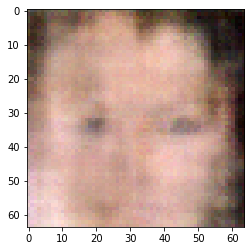

Epoch 1/10... Discriminator Loss: 1.3028... Generator Loss: 0.8541
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


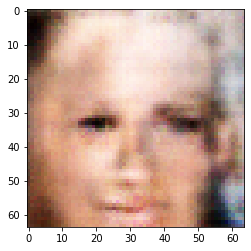

Epoch 1/10... Discriminator Loss: 1.1956... Generator Loss: 0.9212
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


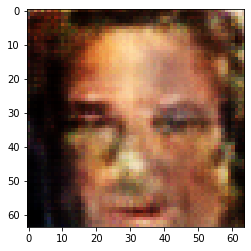

Epoch 1/10... Discriminator Loss: 1.2797... Generator Loss: 1.2798
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


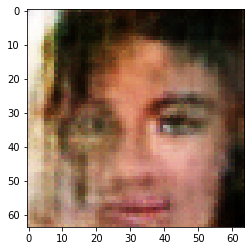

Epoch 1/10... Discriminator Loss: 1.0162... Generator Loss: 0.9253
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


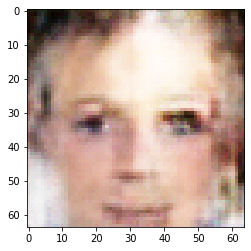

Epoch 1/10... Discriminator Loss: 0.9790... Generator Loss: 1.0507
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


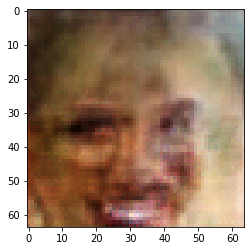

Epoch 1/10... Discriminator Loss: 0.9832... Generator Loss: 1.0917
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


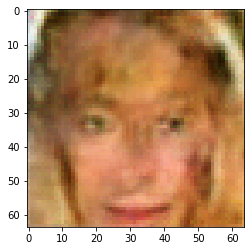

Epoch 1/10... Discriminator Loss: 0.9390... Generator Loss: 1.1149
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


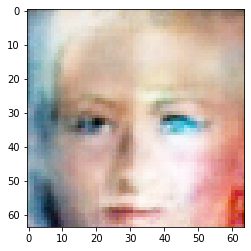

Epoch 1/10... Discriminator Loss: 1.3648... Generator Loss: 0.6005
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


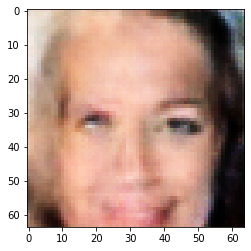

Epoch 1/10... Discriminator Loss: 0.9822... Generator Loss: 1.0147
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


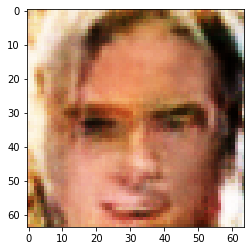

Epoch 1/10... Discriminator Loss: 0.6990... Generator Loss: 1.4467
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


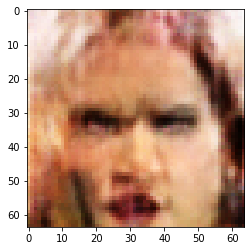

Epoch 1/10... Discriminator Loss: 1.5606... Generator Loss: 0.5021
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


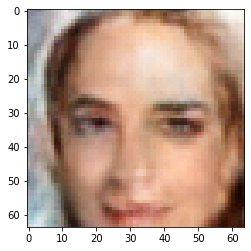

Epoch 1/10... Discriminator Loss: 0.9374... Generator Loss: 1.0183
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


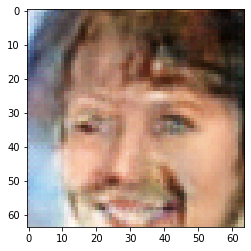

Epoch 1/10... Discriminator Loss: 1.1091... Generator Loss: 0.7400
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


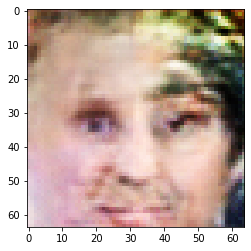

Epoch 1/10... Discriminator Loss: 0.9505... Generator Loss: 0.9766
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


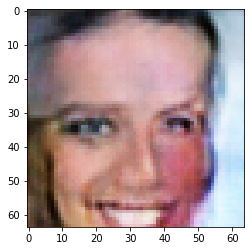

Epoch 1/10... Discriminator Loss: 1.1180... Generator Loss: 0.7434
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


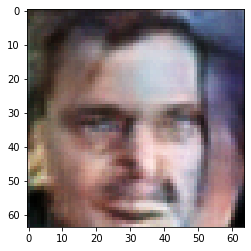

Epoch 1/10... Discriminator Loss: 1.3536... Generator Loss: 0.5465
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


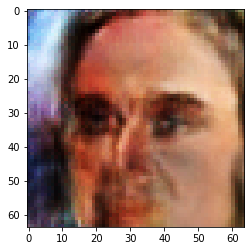

Epoch 1/10... Discriminator Loss: 1.1805... Generator Loss: 0.9176
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


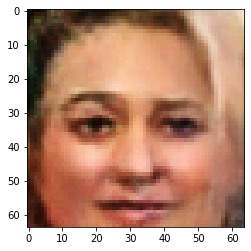

Epoch 1/10... Discriminator Loss: 1.1864... Generator Loss: 0.7212
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


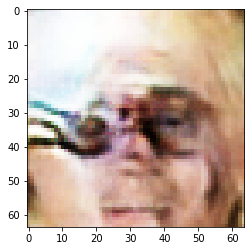

Epoch 1/10... Discriminator Loss: 1.3023... Generator Loss: 0.5594
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


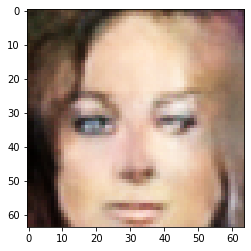

Epoch 1/10... Discriminator Loss: 0.6406... Generator Loss: 1.6687
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


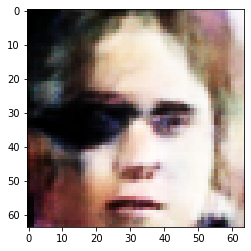

Epoch 1/10... Discriminator Loss: 0.9641... Generator Loss: 0.8852
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


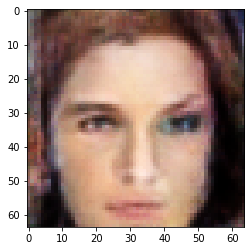

Epoch 1/10... Discriminator Loss: 1.0901... Generator Loss: 0.7275
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


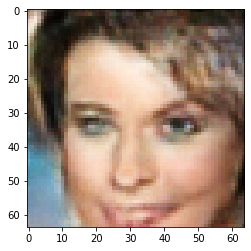

Epoch 1/10... Discriminator Loss: 0.8631... Generator Loss: 1.0257
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


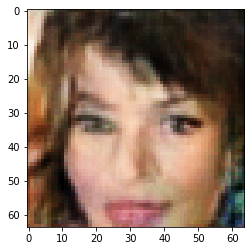

Epoch 1/10... Discriminator Loss: 0.9491... Generator Loss: 0.9307
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


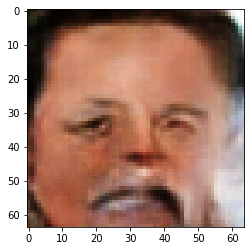

Epoch 1/10... Discriminator Loss: 1.0130... Generator Loss: 0.9681
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


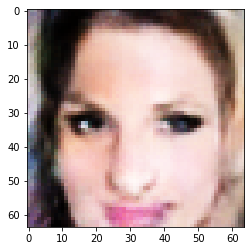

Epoch 1/10... Discriminator Loss: 0.8654... Generator Loss: 1.0118
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


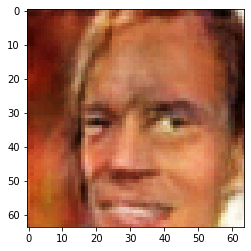

Epoch 1/10... Discriminator Loss: 1.5444... Generator Loss: 0.5224
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


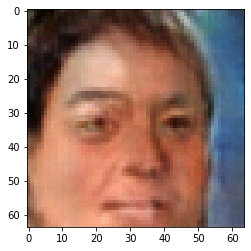

Epoch 1/10... Discriminator Loss: 0.9055... Generator Loss: 1.1337
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


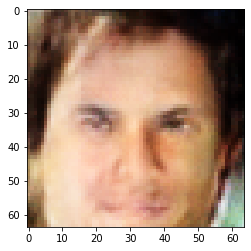

Epoch 1/10... Discriminator Loss: 0.9411... Generator Loss: 0.9784
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


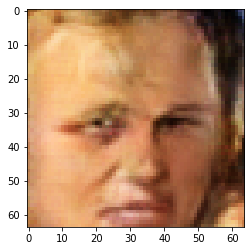

Epoch 2/10... Discriminator Loss: 0.8261... Generator Loss: 1.0285
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


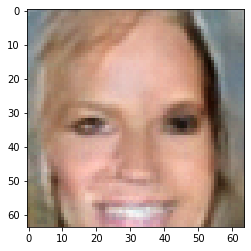

Epoch 2/10... Discriminator Loss: 1.4420... Generator Loss: 0.5176
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


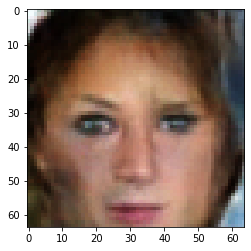

Epoch 2/10... Discriminator Loss: 1.0387... Generator Loss: 0.7863
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


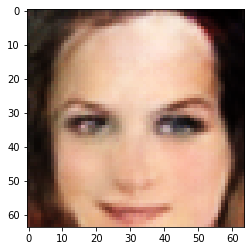

Epoch 2/10... Discriminator Loss: 1.3877... Generator Loss: 0.5355
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


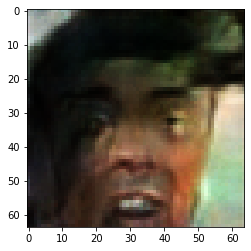

Epoch 2/10... Discriminator Loss: 1.2322... Generator Loss: 0.6166
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


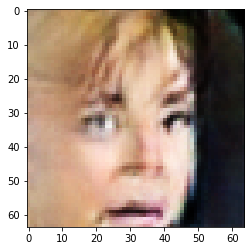

Epoch 2/10... Discriminator Loss: 1.4260... Generator Loss: 0.5249
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


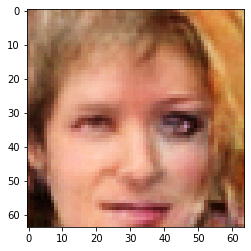

Epoch 2/10... Discriminator Loss: 1.0534... Generator Loss: 0.9819
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


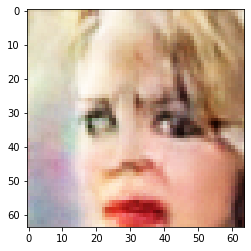

Epoch 2/10... Discriminator Loss: 0.8956... Generator Loss: 1.0172
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


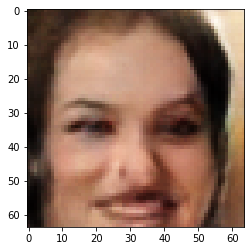

Epoch 2/10... Discriminator Loss: 1.1873... Generator Loss: 0.6314
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


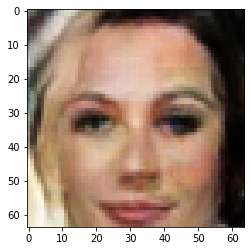

Epoch 2/10... Discriminator Loss: 1.1539... Generator Loss: 2.1726
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


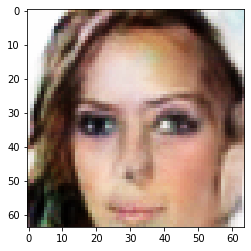

Epoch 2/10... Discriminator Loss: 0.8279... Generator Loss: 1.1293
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


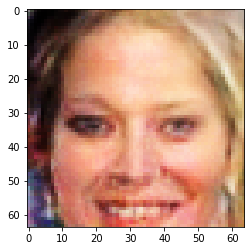

Epoch 2/10... Discriminator Loss: 0.9096... Generator Loss: 1.1150
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


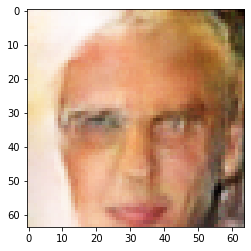

Epoch 2/10... Discriminator Loss: 0.7680... Generator Loss: 1.4191
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


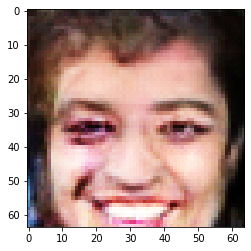

Epoch 2/10... Discriminator Loss: 0.7119... Generator Loss: 1.5022
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


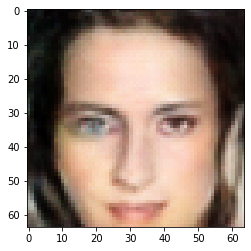

Epoch 2/10... Discriminator Loss: 1.4063... Generator Loss: 0.5125
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


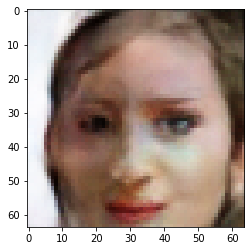

Epoch 2/10... Discriminator Loss: 1.5515... Generator Loss: 0.5112
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


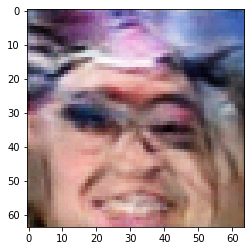

Epoch 2/10... Discriminator Loss: 1.2775... Generator Loss: 0.6007
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


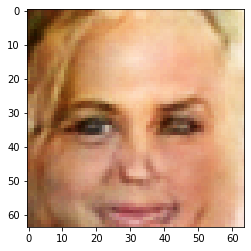

Epoch 2/10... Discriminator Loss: 1.1944... Generator Loss: 0.6742
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


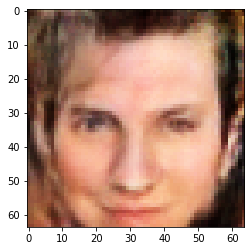

Epoch 2/10... Discriminator Loss: 1.0195... Generator Loss: 0.8569
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


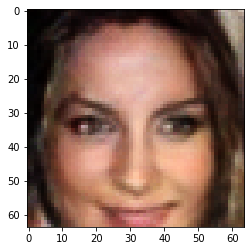

Epoch 2/10... Discriminator Loss: 1.3720... Generator Loss: 0.5705
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


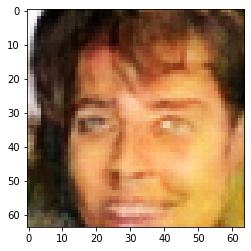

Epoch 2/10... Discriminator Loss: 0.8367... Generator Loss: 1.1667
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


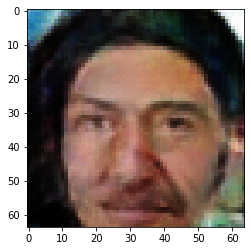

Epoch 2/10... Discriminator Loss: 0.7532... Generator Loss: 1.2856
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


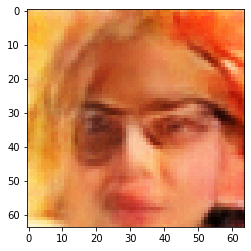

Epoch 2/10... Discriminator Loss: 0.8885... Generator Loss: 1.0767
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


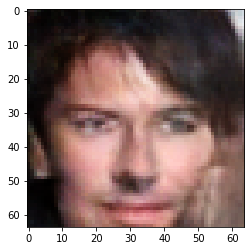

Epoch 2/10... Discriminator Loss: 0.8344... Generator Loss: 1.1129
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


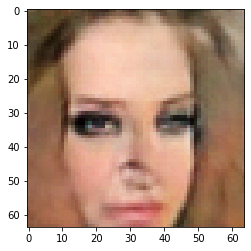

Epoch 2/10... Discriminator Loss: 0.8173... Generator Loss: 1.0202
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


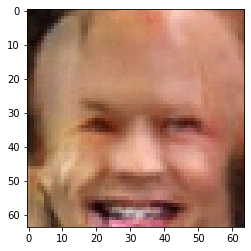

Epoch 2/10... Discriminator Loss: 1.8038... Generator Loss: 0.4239
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


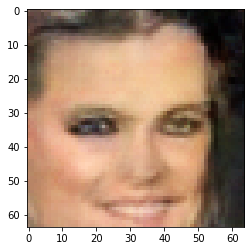

Epoch 2/10... Discriminator Loss: 0.6085... Generator Loss: 1.5704
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


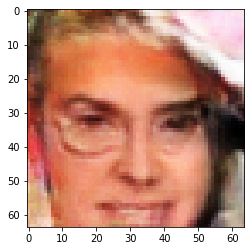

Epoch 2/10... Discriminator Loss: 0.9375... Generator Loss: 0.9120
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


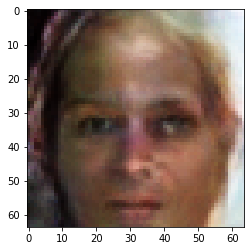

Epoch 2/10... Discriminator Loss: 0.9272... Generator Loss: 0.8411
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


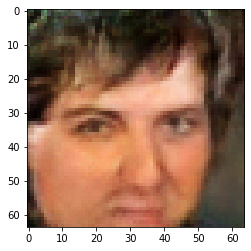

Epoch 2/10... Discriminator Loss: 0.7541... Generator Loss: 1.2016
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


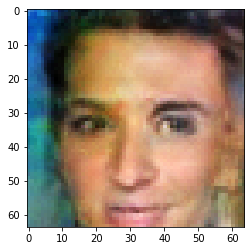

Epoch 2/10... Discriminator Loss: 0.9374... Generator Loss: 0.8611
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


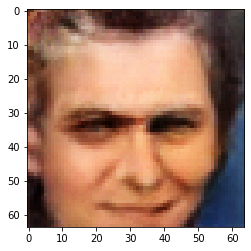

Epoch 2/10... Discriminator Loss: 0.8435... Generator Loss: 1.5445
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


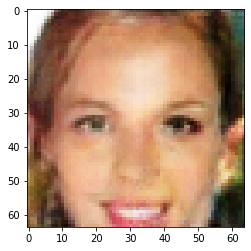

Epoch 3/10... Discriminator Loss: 0.7454... Generator Loss: 1.2314
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


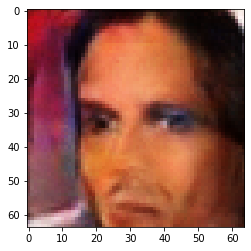

Epoch 3/10... Discriminator Loss: 0.6276... Generator Loss: 1.5090
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


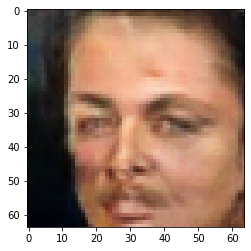

Epoch 3/10... Discriminator Loss: 0.7135... Generator Loss: 1.4279
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


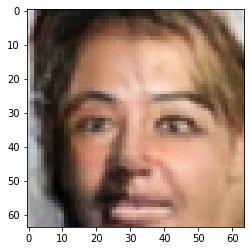

Epoch 3/10... Discriminator Loss: 0.7139... Generator Loss: 2.0463
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


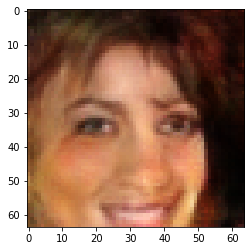

Epoch 3/10... Discriminator Loss: 0.7135... Generator Loss: 1.3873
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


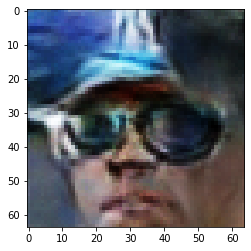

Epoch 3/10... Discriminator Loss: 0.6725... Generator Loss: 1.3199
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


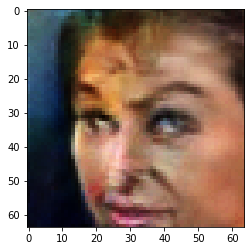

Epoch 3/10... Discriminator Loss: 1.1773... Generator Loss: 0.6857
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


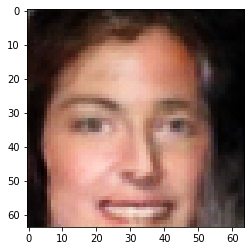

Epoch 3/10... Discriminator Loss: 1.0254... Generator Loss: 0.7674
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


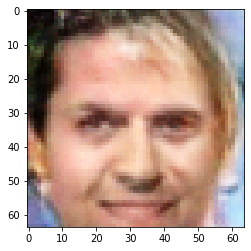

Epoch 3/10... Discriminator Loss: 0.5234... Generator Loss: 2.1183
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


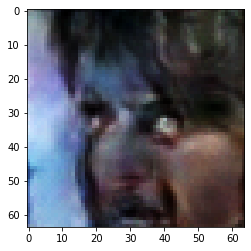

Epoch 3/10... Discriminator Loss: 1.1329... Generator Loss: 0.6929
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


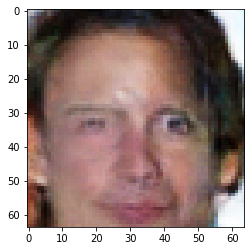

Epoch 3/10... Discriminator Loss: 0.5669... Generator Loss: 1.6291
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


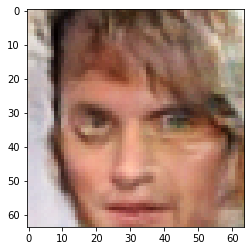

Epoch 3/10... Discriminator Loss: 0.6462... Generator Loss: 1.3612
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


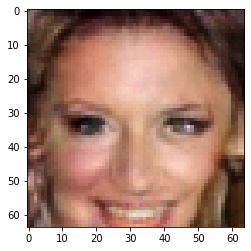

Epoch 3/10... Discriminator Loss: 1.3252... Generator Loss: 0.6733
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


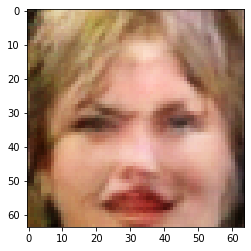

Epoch 3/10... Discriminator Loss: 0.6818... Generator Loss: 1.3959
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


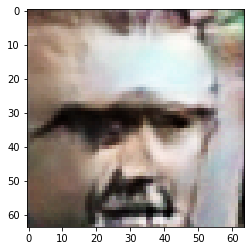

Epoch 3/10... Discriminator Loss: 0.5337... Generator Loss: 2.1274
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


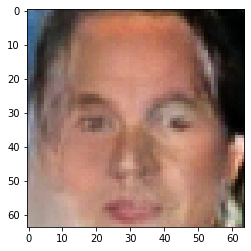

Epoch 3/10... Discriminator Loss: 1.1481... Generator Loss: 0.7076
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


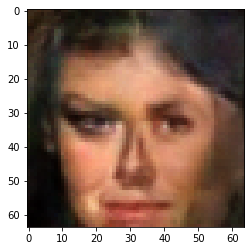

Epoch 3/10... Discriminator Loss: 0.5379... Generator Loss: 1.8884
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


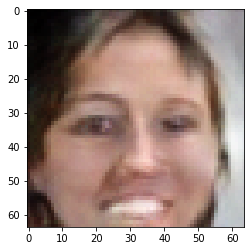

Epoch 3/10... Discriminator Loss: 0.7303... Generator Loss: 1.2060
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


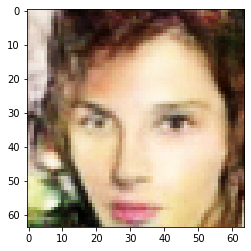

Epoch 3/10... Discriminator Loss: 0.6285... Generator Loss: 2.1992
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


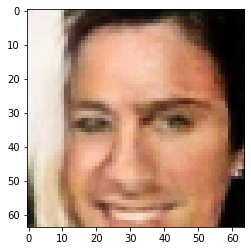

Epoch 3/10... Discriminator Loss: 1.0109... Generator Loss: 0.8201
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


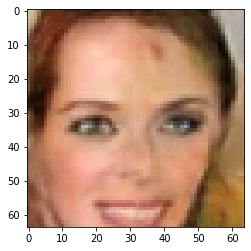

Epoch 3/10... Discriminator Loss: 0.9525... Generator Loss: 1.1302
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


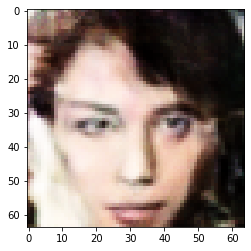

Epoch 3/10... Discriminator Loss: 0.6107... Generator Loss: 1.8047
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


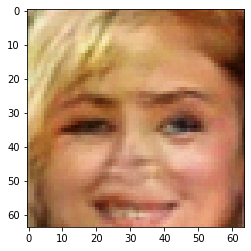

Epoch 3/10... Discriminator Loss: 0.4434... Generator Loss: 2.7936
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


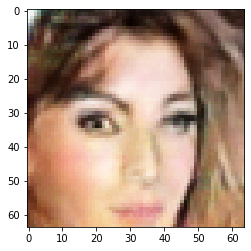

Epoch 3/10... Discriminator Loss: 0.6912... Generator Loss: 1.3457
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


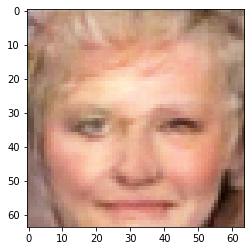

Epoch 3/10... Discriminator Loss: 0.9459... Generator Loss: 0.9561
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


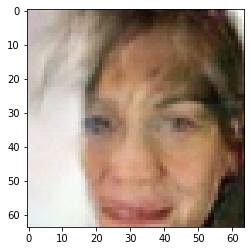

Epoch 3/10... Discriminator Loss: 0.5625... Generator Loss: 2.6271
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


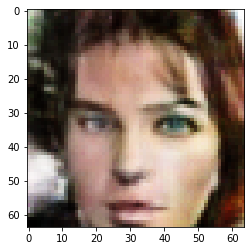

Epoch 3/10... Discriminator Loss: 0.9092... Generator Loss: 0.9132
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


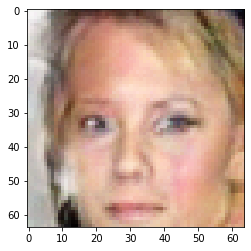

Epoch 3/10... Discriminator Loss: 0.5186... Generator Loss: 2.1653
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


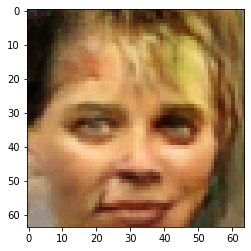

Epoch 3/10... Discriminator Loss: 0.6230... Generator Loss: 1.7155
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


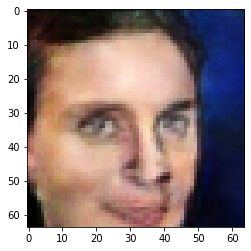

Epoch 3/10... Discriminator Loss: 0.5733... Generator Loss: 1.7126
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


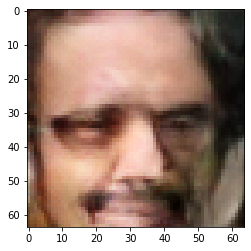

Epoch 3/10... Discriminator Loss: 0.5247... Generator Loss: 2.3076
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


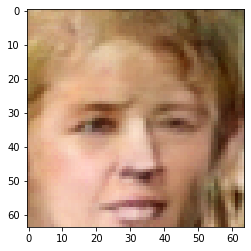

Epoch 4/10... Discriminator Loss: 0.8007... Generator Loss: 1.1271
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


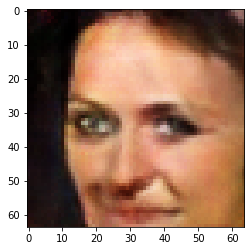

Epoch 4/10... Discriminator Loss: 1.1658... Generator Loss: 0.7006
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


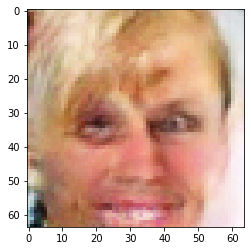

Epoch 4/10... Discriminator Loss: 0.5084... Generator Loss: 1.9662
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


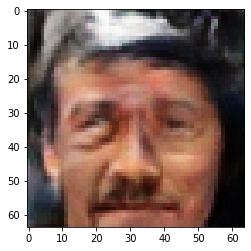

Epoch 4/10... Discriminator Loss: 0.6690... Generator Loss: 1.4535
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


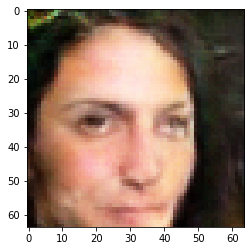

Epoch 4/10... Discriminator Loss: 0.7172... Generator Loss: 1.2090
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


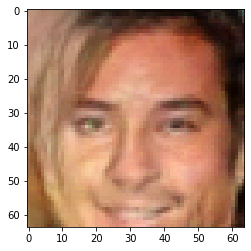

Epoch 4/10... Discriminator Loss: 0.6903... Generator Loss: 1.4312
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


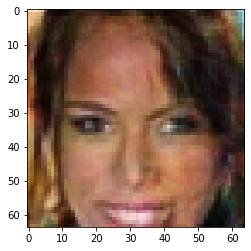

Epoch 4/10... Discriminator Loss: 0.4884... Generator Loss: 2.2443
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


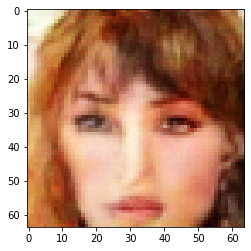

Epoch 4/10... Discriminator Loss: 0.4077... Generator Loss: 2.7130
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


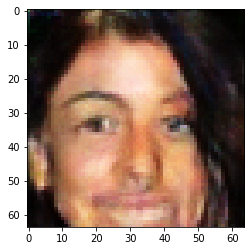

Epoch 4/10... Discriminator Loss: 0.4458... Generator Loss: 3.1637
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


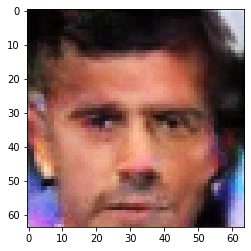

Epoch 4/10... Discriminator Loss: 0.5933... Generator Loss: 1.6398
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


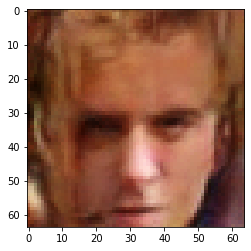

Epoch 4/10... Discriminator Loss: 0.7344... Generator Loss: 1.2214
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


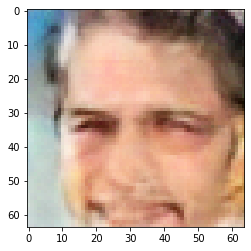

Epoch 4/10... Discriminator Loss: 1.5602... Generator Loss: 0.6151
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


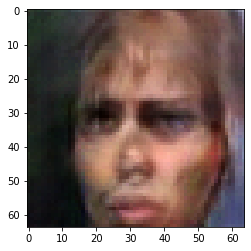

Epoch 4/10... Discriminator Loss: 0.6137... Generator Loss: 1.4830
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


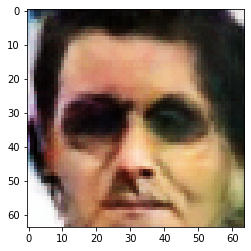

Epoch 4/10... Discriminator Loss: 1.3754... Generator Loss: 0.6117
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


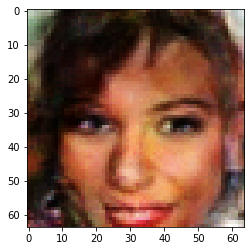

Epoch 4/10... Discriminator Loss: 0.6871... Generator Loss: 1.3641
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


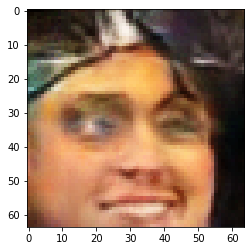

Epoch 4/10... Discriminator Loss: 0.4268... Generator Loss: 3.2705
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


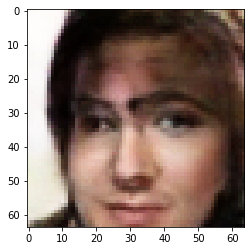

Epoch 4/10... Discriminator Loss: 1.3274... Generator Loss: 0.7101
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


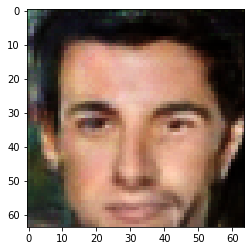

Epoch 4/10... Discriminator Loss: 0.5009... Generator Loss: 2.0251
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


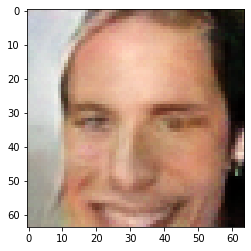

Epoch 4/10... Discriminator Loss: 0.6698... Generator Loss: 1.3394
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


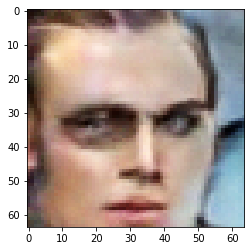

Epoch 4/10... Discriminator Loss: 0.5455... Generator Loss: 2.1249
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


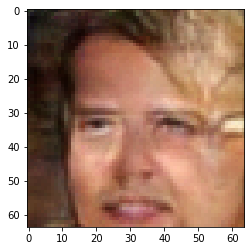

Epoch 4/10... Discriminator Loss: 0.7648... Generator Loss: 1.2535
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


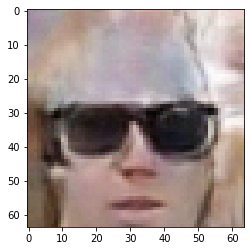

Epoch 4/10... Discriminator Loss: 0.4928... Generator Loss: 2.0467
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


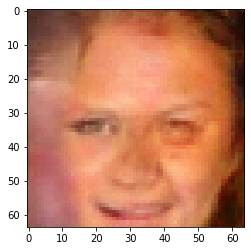

Epoch 4/10... Discriminator Loss: 0.4363... Generator Loss: 2.6561
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


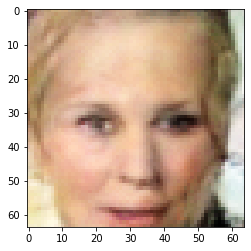

Epoch 4/10... Discriminator Loss: 0.5068... Generator Loss: 2.2251
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


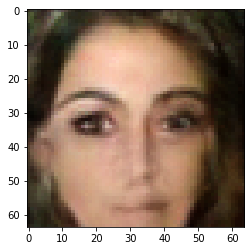

Epoch 4/10... Discriminator Loss: 1.1020... Generator Loss: 0.7880
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


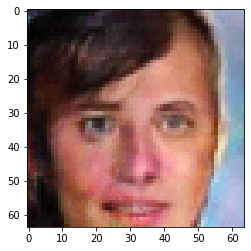

Epoch 4/10... Discriminator Loss: 0.9135... Generator Loss: 0.9640
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


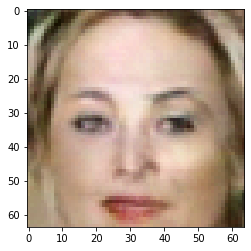

Epoch 4/10... Discriminator Loss: 0.5117... Generator Loss: 2.0699
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


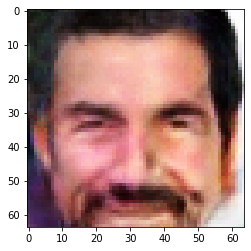

Epoch 4/10... Discriminator Loss: 0.4313... Generator Loss: 2.8969
gen/z:(?, 100)
gen/x_1:(?, 2048)
gen/lrelu2:(?, 2, 2, 512)
gen/lrelu3:(?, 8, 8, 256)
gen/lrelu4:(?, 32, 32, 128)
gen/logits:(?, 64, 64, 3)


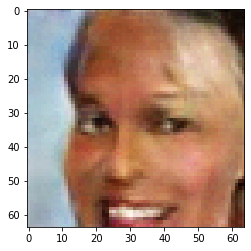

KeyboardInterrupt: 

In [20]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 10
print(shape)

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)